# CSCI-537 Final Project
# CAPTCHA Solver
### Fall 2021
### Hayden Sather, Jake Pinkston

### TO RUN: Extract the hard_data and easy_data directories to the project directory

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

import global_params as gp
import helper_funcs as hf

In [2]:
model = hf.get_model(retrain=False)

2021-12-03 19:55:16.566601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 19:55:16.570361: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-12-03 19:55:16.570372: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-03 19:55:16.570610: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

909/909 [==============================] - 5s 5ms/step - loss: 0.3946 - accuracy: 0.8573
Accuracy on EMNIST test data: 0.8572853207588196


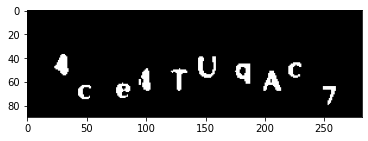

80.0


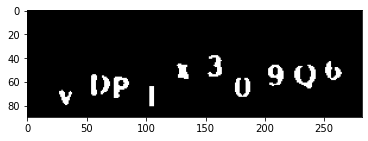

50.0


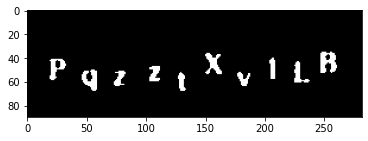

53.333333333333336


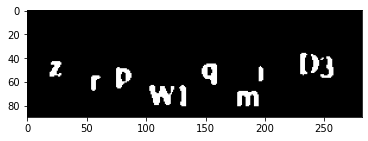

42.5


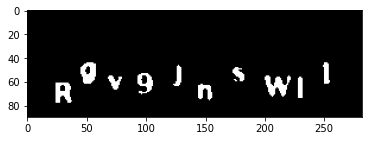

52.0


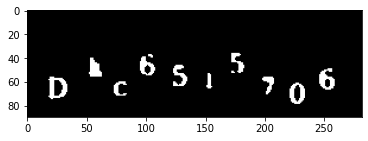

56.666666666666664


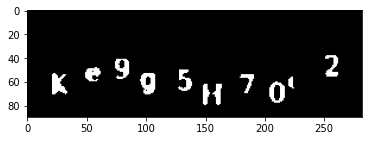

54.285714285714285


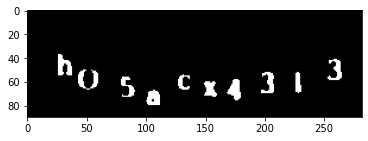

57.5


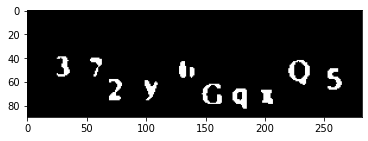

60.0


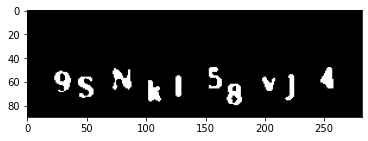

63.0


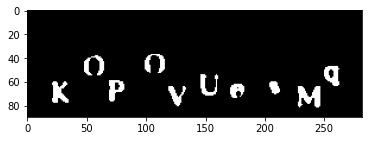

62.72727272727273


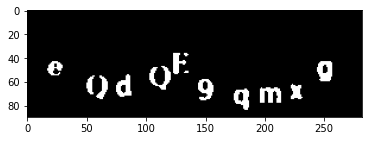

58.333333333333336


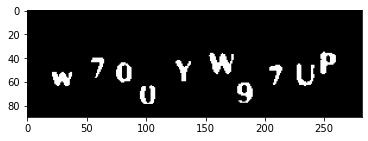

58.46153846153846


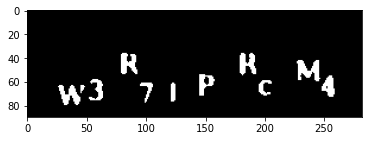

60.0


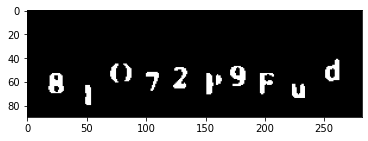

61.333333333333336


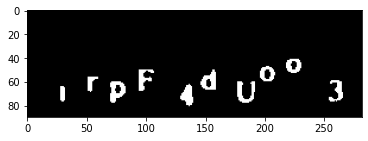

62.5


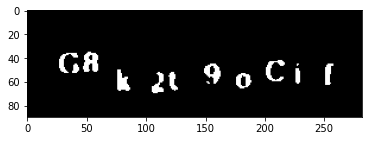

62.94117647058823


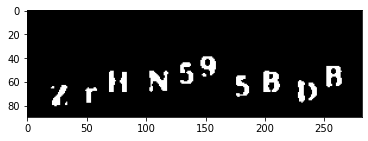

KeyboardInterrupt: 

In [5]:
def read_captcha(img):
    # Invert color
    img = 255 - img
    # Take the max of each band
    img = np.max(img, axis=2)
    # Denoise
    img = cv2.fastNlMeansDenoising(img,None,10,3,27)
    # Threshold 
    _, img_thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)
    num_components, _, _, centroids = cv2.connectedComponentsWithStats(img_thresh, 1, cv2.CV_8U)
    # Normalize
    img = img / 255
    img[img >= gp.PIXEL_THRESH] = 1
    img[img < gp.PIXEL_THRESH] = 0

    # TODO Jake: Morphological stuff to make this a little better!

    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()

    x_loc_list = []
    prediction_list = []
    img_width, img_height = gp.IMG_SIZE, gp.IMG_SIZE
    for i in range(1, num_components):
        centroid = centroids[i]
        centroid = [round(x) for x in centroid]
        left = round(centroid[1] - gp.IMG_SIZE/2)
        right = round(centroid[1] + gp.IMG_SIZE/2)
        top = round(centroid[0] - gp.IMG_SIZE/2)
        bottom = round(centroid[0] + gp.IMG_SIZE/2)
        img_slice = img[left:right, top:bottom]
        img_slice_exp = np.expand_dims(img_slice, axis=0)

        if img_slice_exp.shape != (1, gp.IMG_SIZE, gp.IMG_SIZE):
            continue

        prediction = model.predict(img_slice_exp)
        # print("\nConfidence:", np.max(prediction))
        decoded_value = hf.decode_prediction(prediction)
        # print("Predicted value:", decoded_value)

        # plt.imshow(img_slice, cmap=plt.get_cmap('gray'))
        # plt.show()

        x_loc_list.append(top)
        prediction_list.append(decoded_value)

    zipped_lists = zip(x_loc_list, prediction_list)
    sorted_pairs = sorted(zipped_lists)

    sorted_pairs = zip(*sorted_pairs)
    _, output = (list(pair) for pair in sorted_pairs)
    output = "".join(output)

    return output


def characters_match(pred_char, true_char):
    pred_char = pred_char.upper()
    true_char = true_char.upper()
    if pred_char in gp.CHAR_MAPPING:
        pred_char = gp.CHAR_MAPPING[pred_char]
    if true_char in gp.CHAR_MAPPING:
        true_char = gp.CHAR_MAPPING[true_char]

    return pred_char == true_char


def calc_percent_correct(true_captcha, predicted_captcha):
    num_matches = 0
    for true_char, pred_char in zip(true_captcha, predicted_captcha):
        if characters_match(pred_char, true_char):
            num_matches += 1
    percent_correct = 100 * (num_matches / len(true_captcha))

    return percent_correct

agg_correct = 0
num_total = 0
for filename in os.listdir("easy_data"):
    img_path = os.path.join("easy_data", filename)
    true_captcha = filename[:-4]

    img = cv2.imread(img_path)
    predicted_captcha = read_captcha(img)
    
    percent_correct = calc_percent_correct(true_captcha, predicted_captcha)

    # print(true_captcha)
    # print(predicted_captcha)
    # print(percent_correct, "\n")

    agg_correct += percent_correct
    num_total += 1

    print(agg_correct / num_total)

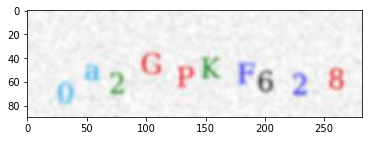


Confidence: 0.32195392
Predicted value: 1


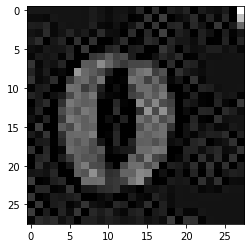


Confidence: 0.3108953
Predicted value: 1


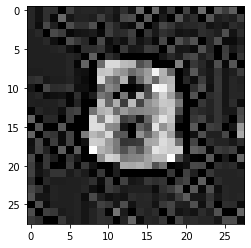


Confidence: 0.26669738
Predicted value: 1


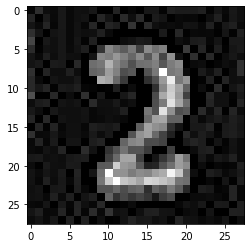


Confidence: 0.15995078
Predicted value: 1


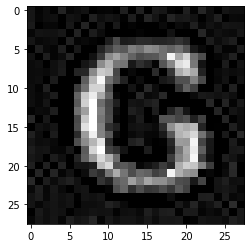


Confidence: 0.13554832
Predicted value: 1


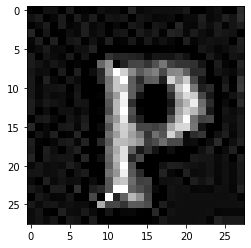


Confidence: 0.301081
Predicted value: 1


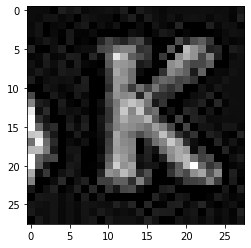


Confidence: 0.2678264
Predicted value: 1


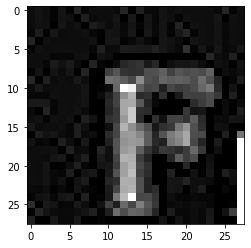


Confidence: 0.12823139
Predicted value: 1


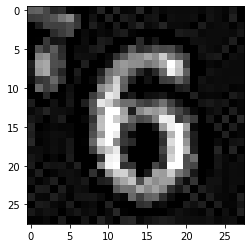


Confidence: 0.27111503
Predicted value: 1


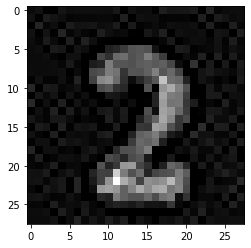


Confidence: 0.122644596
Predicted value: 1


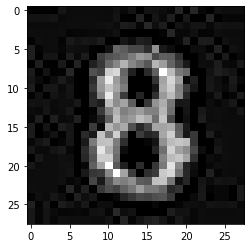

In [4]:
# Using Connected Components on easy data
def consolidate_centroids(centroids,area,distance): #recursive algorithm made that gets rid of duplicates or other nearby centroids within distance
    for i in range(len(centroids)):
        for j in range(len(centroids)):
            if i ==j:
                continue
            point2point = (abs(centroids[i][0]**2 - centroids[j][0]**2) + abs(centroids[i][1]**2 - centroids[j][1]**2))**.5
            if ( point2point< distance)or area[i]<30 or area[i]>1000 :
                #centroids[j] = [  np.mean([ centroids[i][0],centroids[j][0]]), np.mean([ centroids[i][1],centroids[j][1]]) ]
                final_centroids = np.delete(centroids,(i),0)
                areas.pop(i)
                final_centroids = consolidate_centroids(final_centroids,areas,distance)
                return final_centroids
    return centroids          

img_color= cv2.imread("easy_data/0a2GPKF628.jpg")
plt.imshow(img_color, cmap=plt.get_cmap('gray'))
plt.show()

# Turn greyscale
img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
img = img[:,:280]

#Denoising and filtering for model reading
img_model = cv2.fastNlMeansDenoising(img,None,10,3,27) # have to denoise it before dividing by 255
#img_model = cv2.adaptiveThreshold(img_model,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,7,1)
# plt.imshow(img_model, cmap=plt.get_cmap('gray'))
# plt.show()

#Denoising and threshing for connected components
img_thresh = cv2.fastNlMeansDenoising(img,None,10,3,27) # have to denoise it before dividing by 255
img_thresh = cv2.adaptiveThreshold(img_thresh,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,7,3)
_,img_thresh = cv2.threshold(img_thresh,240,255, cv2.THRESH_BINARY_INV)


num_labels,labels,stats,centroids = cv2.connectedComponentsWithStats(img_thresh, 4, cv2.CV_32S) #connected components function

#returns areas for connected components stats variable
areas = []
for i in stats:
    areas.append(i[4])

dst_tolerance = 25#tolerance for nearby points
real_centroids = consolidate_centroids(centroids,areas,dst_tolerance)

# converts centroids to tuples for drawing markers then sorts
tup_centroids = []
for i in range(len(real_centroids)): 
    tup_centroids.append( (int(real_centroids[i][0]), int(real_centroids[i][1])) )
tup_centroids.sort(key = lambda x:x[0])

#draws markers
for i in range(len(tup_centroids)):
    cv2.drawMarker(img_thresh,tup_centroids[i],[0,0,255])
# plt.imshow(img_thresh, cmap=plt.get_cmap('gray'))
# plt.show()

for i in range(len(tup_centroids)):
    img_slice = img_model[tup_centroids[i][1]-14:tup_centroids[i][1]+14,tup_centroids[i][0]-14:tup_centroids[i][0]+14]

    kernel = np.array([[0, -1, 0],
                    [-1, 5,-1],
                    [0, -1, 0]])
    for i in range(2):
        img_slice = cv2.filter2D(src=img_slice, ddepth=-1, kernel=kernel)
    # img_slice = cv2.adaptiveThreshold(img_slice,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,7,1)

    #_,img_slice = cv2.threshold(img_slice,220,255,cv2.THRESH_BINARY)

    #_,img_slice = cv2.threshold(img_slice,180,255,cv2.THRESH_BINARY)
    #img_slice = cv2.morphologyEx(img_slice,cv2.MORPH_OPEN,np.ones(3))
    #img_slice = cv2.blur(img_slice,(3,3)) #blur image

    # _,img_slice = cv2.ada(img_slice,150,255, cv2.THRESH_BINARY)

    #image sharpening
    img_slice=255-img_slice
   

    img_slice = img_slice.astype("float32") / 255

    img_slice_fixed = np.expand_dims(img_slice, -1)
    img_slice_fixed = np.expand_dims(img_slice_fixed, 0)
    prediction = model.predict(img_slice_fixed)
    print("\nConfidence:", np.max(prediction))
    decoded_value = hf.decode_prediction(prediction)
    print("Predicted value:", decoded_value)
    plt.imshow(img_slice, cmap=plt.get_cmap('gray'))
    plt.show()
